# 深層学習を用いた「オセロAI」_DQN

## ゲーム環境の実装
オセロのゲームを信仰させるためのクラスを作成する。盤面の状態、合法手の判定、石を置く処理を設定する

In [ ]:
# セル1: ゲーム環境
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import time # 学習時間の計測用

class OthelloGame:
    def __init__(self, n=8):
        assert n % 2 == 0, "Board size must be even."
        self.n = n
        self.board = np.zeros((n, n), dtype=int)
        mid = n // 2
        self.board[mid-1, mid-1] = self.board[mid, mid] = 1
        self.board[mid-1, mid] = self.board[mid, mid-1] = -1
        self.current_player = -1

    def get_valid_moves(self, player):
        valid_moves = []
        for r in range(self.n):
            for c in range(self.n):
                if self.board[r, c] == 0:
                    for dr in [-1, 0, 1]:
                        for dc in [-1, 0, 1]:
                            if dr == 0 and dc == 0:
                                continue
                            r_check, c_check = r + dr, c + dc
                            flipped_stones = []
                            while 0 <= r_check < self.n and 0 <= c_check < self.n:
                                if self.board[r_check, c_check] == -player:
                                    flipped_stones.append((r_check, c_check))
                                    r_check += dr
                                    c_check += dc
                                elif self.board[r_check, c_check] == player:
                                    if flipped_stones:
                                        valid_moves.append((r, c))
                                    break
                                else:
                                    break
        return list(set(valid_moves))

    def make_move(self, move, player):
        if move not in self.get_valid_moves(player):
            return False
        r, c = move
        self.board[r, c] = player
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:
                    continue
                r_check, c_check = r + dr, c + dc
                flipped_stones = []
                while 0 <= r_check < self.n and 0 <= c_check < self.n:
                    if self.board[r_check, c_check] == -player:
                        flipped_stones.append((r_check, c_check))
                        r_check += dr
                        c_check += dc
                    elif self.board[r_check, c_check] == player:
                        for fr, fc in flipped_stones:
                            self.board[fr, fc] = player
                        break
                    else:
                        break
        return True

    def is_game_over(self):
        return not self.get_valid_moves(-1) and not self.get_valid_moves(1)

    def get_winner(self):
        black_stones = np.sum(self.board == -1)
        white_stones = np.sum(self.board == 1)
        if black_stones > white_stones: return -1
        elif white_stones > black_stones: return 1
        else: return 0

    def get_board_state(self):
        return self.board.copy()

## DQNエージェントの実装
強化学習でオセロを学習エージェントを作成する。盤面を画像のようにとらえて判断するCNNをモデルとして使用。

In [ ]:
# セル2: AIエージェント
class QNetwork(nn.Module):
    def __init__(self, n=8):
        super(QNetwork, self).__init__()
        self.n = n
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * n * n, 256)
        self.fc2 = nn.Linear(256, n * n)

    def forward(self, x):
        x = x.view(-1, 1, self.n, self.n)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class DQNAgent:
    def __init__(self, n=8, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, device='cpu'):
        self.n = n
        self.device = device
        self.q_network = QNetwork(n).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = deque(maxlen=10000)

    def choose_action(self, state, valid_moves, player):
        if not valid_moves:
            return None
        if random.random() < self.epsilon:
            return random.choice(valid_moves)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state * player).unsqueeze(0).to(self.device)
                q_values = self.q_network(state_tensor).squeeze(0)
                valid_q_values = torch.full((self.n * self.n,), -float('inf'), device=self.device)
                for r, c in valid_moves:
                    valid_q_values[r * self.n + c] = q_values[r * self.n + c]
                action_idx = torch.argmax(valid_q_values).item()
                return (action_idx // self.n, action_idx % self.n)

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def learn(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor([a[0] * self.n + a[1] for a in actions]).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.q_network(next_states).max(1)[0]
        target_q = rewards + self.gamma * next_q_values * (1 - dones)
        loss = nn.MSELoss()(current_q, target_q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## 学習
先ほど作成したゲーム環境とエージェントを使って自己対戦を進める

In [ ]:
#セル3: 学習ループ

def train(episodes=1000, batch_size=64):
    n = 8
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    agent = DQNAgent(n, device=device)
    start_time = time.time()

    # 可視化用の履歴データ
    history = {
        'episode': [],
        'black_win_rate': [],
        'white_win_rate': [],
        'draw_rate': [],
        'epsilon': []
    }

    win_counts = {-1: 0, 1: 0, 0: 0} # 黒の勝ち, 白の勝ち, 引き分け
    total_games_in_interval = 0
    interval = 100 # 100エピソードごとに記録

    for e in range(episodes):
        game = OthelloGame(n)
        state = game.get_board_state()
        last_transitions = { -1: None, 1: None }

        while True:
            current_player = game.current_player
            valid_moves = game.get_valid_moves(current_player)

            if not valid_moves:
                game.current_player *= -1
                if not game.get_valid_moves(game.current_player):
                    break
                continue

            action = agent.choose_action(state, valid_moves, current_player)

            if last_transitions[current_player * -1] is not None:
                s, a, _, _, _ = last_transitions[current_player * -1]
                agent.store_transition(s, a, 0, state * (current_player * -1), False)

            game.make_move(action, current_player)
            next_state = game.get_board_state()
            last_transitions[current_player] = (state * current_player, action, 0, next_state * current_player, False)
            state = next_state

            if game.is_game_over():
                break

            game.current_player *= -1

        winner = game.get_winner()
        win_counts[winner] += 1
        total_games_in_interval += 1

        if last_transitions[-1] is not None:
            s, a, _, ns, _ = last_transitions[-1]
            reward = winner * -1
            agent.store_transition(s, a, reward, ns, True)

        if last_transitions[1] is not None:
            s, a, _, ns, _ = last_transitions[1]
            reward = winner * 1
            agent.store_transition(s, a, reward, ns, True)

        if len(agent.memory) > batch_size:
            agent.learn(batch_size)

        # 100エピソードごとに進捗と履歴を記録
        if (e + 1) % interval == 0:
            elapsed_time = time.time() - start_time

            # 勝率を計算
            black_win_rate = win_counts[-1] / total_games_in_interval
            white_win_rate = win_counts[1] / total_games_in_interval
            draw_rate = win_counts[0] / total_games_in_interval

            # 履歴に追加
            history['episode'].append(e + 1)
            history['black_win_rate'].append(black_win_rate)
            history['white_win_rate'].append(white_win_rate)
            history['draw_rate'].append(draw_rate)
            history['epsilon'].append(agent.epsilon)

            print(f"Episode {e+1}/{episodes} | Time: {elapsed_time:.2f}s | Epsilon: {agent.epsilon:.4f}")
            print(f"  Win Rates (last 100 games) -> Black: {black_win_rate:.2%}, White: {white_win_rate:.2%}, Draw: {draw_rate:.2%}")

            # カウンターをリセット
            win_counts = {-1: 0, 1: 0, 0: 0}
            total_games_in_interval = 0

    torch.save(agent.q_network.state_dict(), "othello_dqn_model.pth")
    print("\nModel saved as othello_dqn_model.pth")

    return history

In [ ]:
# セル4: 学習を開始
history = train(episodes=10000)

Using device: cuda
Episode 100/10000 | Time: 3.79s | Epsilon: 0.6088
  Win Rates (last 100 games) -> Black: 55.00%, White: 45.00%, Draw: 0.00%
Episode 200/10000 | Time: 9.51s | Epsilon: 0.3688
  Win Rates (last 100 games) -> Black: 49.00%, White: 47.00%, Draw: 4.00%
Episode 300/10000 | Time: 15.03s | Epsilon: 0.2234
  Win Rates (last 100 games) -> Black: 37.00%, White: 60.00%, Draw: 3.00%
Episode 400/10000 | Time: 21.68s | Epsilon: 0.1353
  Win Rates (last 100 games) -> Black: 49.00%, White: 50.00%, Draw: 1.00%
Episode 500/10000 | Time: 27.93s | Epsilon: 0.0820
  Win Rates (last 100 games) -> Black: 44.00%, White: 52.00%, Draw: 4.00%
Episode 600/10000 | Time: 35.03s | Epsilon: 0.0497
  Win Rates (last 100 games) -> Black: 48.00%, White: 46.00%, Draw: 6.00%
Episode 700/10000 | Time: 41.56s | Epsilon: 0.0301
  Win Rates (last 100 games) -> Black: 51.00%, White: 43.00%, Draw: 6.00%
Episode 800/10000 | Time: 48.74s | Epsilon: 0.0182
  Win Rates (last 100 games) -> Black: 51.00%, White: 48.

## 学習の推移を可視化
学習の推移を可視化することでうまく学習が進んだかを判断する考察の材料とする

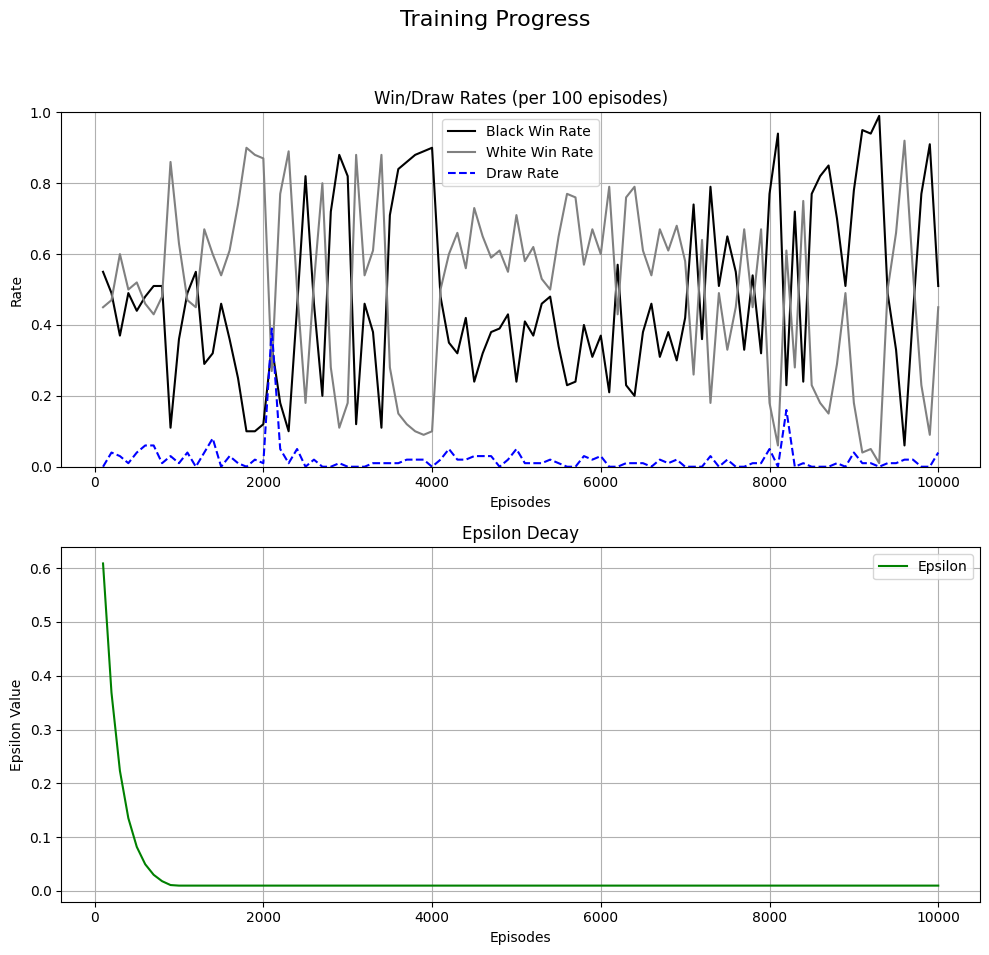

In [ ]:
# セル5: 学習推移の可視化

import matplotlib.pyplot as plt

# グラフ描画エリアを2つに分割
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
fig.suptitle('Training Progress', fontsize=16)

# 1. 勝率の推移
ax1.plot(history['episode'], history['black_win_rate'], label='Black Win Rate', color='black')
ax1.plot(history['episode'], history['white_win_rate'], label='White Win Rate', color='gray')
ax1.plot(history['episode'], history['draw_rate'], label='Draw Rate', color='blue', linestyle='--')
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Rate')
ax1.set_title('Win/Draw Rates (per 100 episodes)')
ax1.legend()
ax1.grid(True)
# Y軸を0%から100%に設定
ax1.set_ylim(0, 1)

# 2. Epsilonの推移
ax2.plot(history['episode'], history['epsilon'], label='Epsilon', color='green')
ax2.set_xlabel('Episodes')
ax2.set_ylabel('Epsilon Value')
ax2.set_title('Epsilon Decay')
ax2.legend()
ax2.grid(True)

# レイアウトを調整して表示
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()